In [1]:
import numpy as np
import math
import os
os.chdir("/notebooks")
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split

In [49]:
def data_generation(c,v,modes,noise_level,error=0,save_GIF=True,save_arrays=True,scaled=False):
    
    final_T   = 4
    L         = 1
    k1  = 1-error
    k2  = 1-error
    v_new = v/k2
    c_new = np.sqrt((c**2-v**2)/k1 + v_new**2)
    
    def random_coefs_generator(modes):
        """
        generating an array of n coeficients, each smaller than the previous
        """
        A = np.zeros(modes)
        for i in range(modes):
            random = np.random.rand()
            if i == 0:
                A[i] = random
            else:
                while random > A[i-1]:
                    random = np.random.rand()
                A[i] = random
        return A
    
    
    A         = random_coefs_generator(modes)
    #A         = [0.08,0.49,0.85,0.35,0.15]
    eps       = 1e-10
    
    #filename to save the GIF and the arrays
    string_coefs = ""
    for elem in A:
        string_coefs += f"{elem:.2f}_"
    
    #spatial domain
    dx = 1/100
    x  = np.arange(0,1+dx,dx)
    print(f"dx is:{dx}")      
        
    
    #time domain
    dt= 1/100
    T = np.arange(0,final_T,step=dt)
    nr_t = len(T)
    print(f"dt is:{dt}")
          
    filename  = f"c={c}_v={v}c_noise={noise_level}_modes=" + string_coefs + f"dt={dt:.3f}_dx={dx:.3f}"
    print("Filename is:",filename)
    
    
    #auxiliary arrays
    omega = np.zeros(modes)
    k_rev = np.zeros(modes)
    k_fwd = np.zeros(modes)
    phi   = np.zeros(modes)
    A_normalized =  np.zeros(modes)
    U = np.zeros((len(T),len(x)))
    
    if scaled:
        omega_new = np.zeros(modes)
        k_rev_new = np.zeros(modes)
        k_fwd_new = np.zeros(modes)
        phi_new   = np.zeros(modes)
        A_normalized_new =  np.zeros(modes)
        U_new = np.zeros((len(T),len(x)))
    #time and space independent variables, only node dependent                 
    for n in range(modes):
        omega[n]        = (n+1) * np.pi / L * (c**2 - v**2)/c
        k_rev[n]        = (n+1) * np.pi / L * (c + v)/c
        k_fwd[n]        = (n+1) * np.pi / L * (c - v)/c
        phi[n]          =-(n+1) * (np.pi * (c+v)/(2*c)-np.pi/2)
        #aux             = np.sin(k_rev[n] * x + phi[n]) + np.sin(k_fwd[n] * x - phi[n])
        #A_normalized[n] = A[n]/ (np.max(aux)+eps)
        
        if scaled:
            omega_new[n]        = (n+1) * np.pi / L * (c_new**2 - v_new**2)/c_new
            k_rev_new[n]        = (n+1) * np.pi / L * (c_new + v_new)/c_new
            k_fwd_new[n]        = (n+1) * np.pi / L * (c_new - v_new)/c_new
            phi_new[n]          =-(n+1) * (np.pi * (c_new+v_new)/(2*c_new)-np.pi/2)
            aux_new             = np.sin(k_rev_new[n] * x + phi_new[n]) + np.sin(k_fwd_new[n] * x - phi_new[n])
            #A_normalized_new[n] = A[n]/ (np.max(aux)+eps)
        
    #time evolution
    for b,t in enumerate(T):
        U_fwd = np.zeros(len(x))
        U_rev = np.zeros(len(x))
        if scaled:
            U_fwd_new = np.zeros(len(x))
            U_rev_new = np.zeros(len(x))
        for n in range(modes):
            U_fwd += A[n] * np.sin(k_fwd[n]*x - omega[n]*t - phi[n])
            U_rev += A[n] * np.sin(k_rev[n]*x + omega[n]*t + phi[n])
            if scaled:
                U_fwd_new += A[n] * np.sin(k_fwd_new[n]*x - omega_new[n]*t - phi_new[n])
                U_rev_new += A[n] * np.sin(k_rev_new[n]*x + omega_new[n]*t + phi_new[n])
        
       
        U[b,:] = U_fwd + U_rev
        
        #adding noise - gaussian noise, multiplied by std*noise level to (same as N(0,noise_level*std))
        sigma_noise = noise_level * U[b,:]
        noise = sigma_noise * np.random.rand(np.size(U_fwd))
        U[b,:] = U[b,:] + noise
        
        #U[b,:] = U_fwd + U_rev + noise_level*np.random.rand(np.size(U_fwd))
        
        if scaled:
            U_new[b,:] = U_fwd_new + U_rev_new + noise_level*np.random.rand(np.size(U_fwd_new))

    #saving the GIF and the arrays
    if save_GIF:
        if scaled:
            
            def init():
                for line in lines:
                    line.set_data([],[])
                return lines
            
            def update_plot(i,line1,line2):
                
                line1.set_data(x,U[i,:])
                line2.set_data(x,U_new[i,:])
                lines = (line1,line2)
        
                return lines
        
            fig   = plt.figure(figsize=(15,5))
            ax    = plt.axes(xlim=(0,1),ylim=(-3,3))
            line, = ax.plot([], [], lw=3)
            plt.xlim(0,1)
            plt.ylim(np.min(U),np.max(U))
            plt.ylabel("Displacement")
            plt.title(f"Original Wave and Wave with an error of {error*100}% in the coefficients",fontsize=20)
            lines = []
            lobj1 = ax.plot([],[],lw=3,label="Original")[0]
            lobj2 = ax.plot([],[],lw=3,label="Wave for determined coefficients")[0]
            lines.append(lobj1)
            lines.append(lobj2)
            plt.legend()
            plt.grid()

            anim = FuncAnimation(fig,
                        update_plot,
                        init_func=init,
                        frames=len(T),
                        fargs=(lines),
                         blit=True,
                        interval=100,
                        repeat=True)

            plt.legend()
            anim.save(f"coefficients/gifs/" +filename+ f"_error={error}" +".gif",fps=60,writer="ffmpeg")
            
            
        else:
            #saving the GIF
            print("Saving the GIF")

            def update_plot(i,line):

                line.set_data(x,U[i,:])
                return line

            fig = plt.figure(figsize=(15,5))

            ax = plt.axes(xlim=(0,1),ylim=(-3,3))
            line = plt.plot([],[],lw=3)
            plt.xlim(0,1)
            plt.ylim(np.min(U),np.max(U))
            plt.xlabel("X")
            plt.ylabel("Displacement")
            plt.title(f"c={c}_v={v}c_noise={noise_level}_modes={modes}",fontsize=20)
            anim = FuncAnimation(fig,
                        update_plot,
                        frames=len(T),
                         fargs=(line),
                         blit=False,
                        interval=100,
                        repeat=True)


            anim.save(f"coefficients/gifs/" + filename + f".gif",fps=10,writer="ffmpeg")


            print("GIF saved")
        
    #saving the data arrays into a file, maybe only do it sometime s, because this arrays are small and can be stored in the RAM
    if save_arrays:
        
        def data_split(percentage):
            
            t_train, t_validation = train_test_split(T,test_size=percentage)
            
            X_train      = []
            X_validation = []
            Y_train      = []
            Y_validation = []
            total_X      = []
            total_Y      = []
            
            for t,tt in enumerate(T):
                for m,xx in enumerate(x):
                    total_X.append([tt,xx])
                    total_Y.append([U[t,m]])
                    if tt in t_train:
                        X_train.append([tt,xx])
                        Y_train.append([U[t,m]])
                    
                    else:
                        X_validation.append([tt,xx])
                        Y_validation.append([U[t,m]])
                    
                    
            return X_train, X_validation, Y_train, Y_validation,total_X,total_Y
        
        X_train,X_validation, Y_train, Y_validation,total_X,total_Y = data_split(0.2)
        np.savez(f"String/" + filename + ".npz",X=x,t=T,wave=U,coefs=A,noise=np.array(noise_level),
                c=c,
                v=v,
                X_train = X_train,
                X_validation=X_validation,
                Y_train=Y_train,
                Y_validation=Y_validation,
                total_X     = total_X,
                total_Y     = total_Y
                )
        
    print("Done!")

In [50]:
data_generation(c=3,v=2,modes=5,noise_level=0,save_GIF=False,save_arrays=True,scaled=False)


dx is:0.01
dt is:0.01
Filename is: c=3_v=2c_noise=0_modes=0.91_0.26_0.10_0.07_0.00_dt=0.010_dx=0.010
Done!


In [7]:
!pip install gif

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for gif: filename=gif-3.0.0-py3-none-any.whl size=4816 sha256=128ce87c89a576e22fd71d4ce31bfaee680d02825363430559da1d592e2e3a88
  Stored in directory: /tmp/pip-ephem-wheel-cache-mazfbgrg/wheels/d8/db/4e/e0ce5209665322902834f4e88fa987f4dfa0c08271368ef098
Successfully built gif


In [8]:
from functools import wraps
from io import BytesIO as Buffer
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib.offsetbox import AnchoredText
import gif

@gif.frame
def helper_plot(data_array,x,i,dici):
  
    
    data = data_array.copy()
    c = dici["c"]
    v = dici["v"]
    noise = dici["noise"]
    fig,ax = plt.subplots(figsize=(15,10))
    
    #TIME elapsing annotation
    at = AnchoredText(f"t={i/100}s", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    #real plots
    plt.plot(x,data[i,:],color="orange",linestyle="solid",lw=5,label = "String")
    
    
   
    
    #plt.vlines(x=0,color="r",ymin=-3,ymax=3,lw=4,label="Fixed points")
    #plt.vlines(x=1,color="red",linestyles="dashed",ymin=-3,ymax=3,lw=2)
    
    #plot settings
    plt.plot(0,0)
    plt.xlim(-0.1,1.1)
    plt.ylim(np.min(data),np.max(data))
    plt.xlabel("X")
    plt.ylabel("Displacement")
    plt.legend(fontsize=20)
    plt.grid()
    plt.title(f"Vibrating String with horizontal speed(c={c:2.1f},v={v:2.1f},noise={noise:2.2f}%)")

    
    
def gif_drawer(filename):
    
    save_name = filename.split("/")[-1]
    save_name = save_name.split(".npz")[0]
    data = np.load(filename)
    t = data["t"]
    x = data["X"]
    c = data["c"]
    v = data["v"]
    noise = data["noise"]
    data_array = data["wave"]
    dici = {
        "c":c,
        "v":v,
        "noise":noise
             }
    
    frames = []

    for i in range(data_array.shape[0]):
        frames.append(helper_plot(data_array,x,i,dici))
            
        
    frames[0].save(f"{save_name}.gif",save_all=True,
            append_images=frames[1:],
            duration=4,
            loop=0,
        )   

In [49]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("Noise/data") if isfile(join("Noise/data", f))]
print(onlyfiles)

['c=1_v=0.5c_noise=0.75_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.005.npz', 'c=1_v=0.5c_noise=0.5_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.005.npz', 'c=1_v=0.5c_noise=0.05_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.005.npz', 'c=1_v=0.5c_noise=0.1_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.005.npz', 'c=1_v=0.5c_noise=0.25_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.005.npz', 'c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.005.npz', 'c=1_v=0.5c_noise=0.9_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.005.npz']


In [50]:
for file in onlyfiles:
    gif_drawer("Noise/data/"+file)

In [101]:
def img_saver(filename):
    
    
    
    save_name = filename.split("/")[-1]
    save_name = save_name.split(".npz")[0]
    data = np.load(filename)
    t = data["t"]
    x = data["X"]
    c = data["c"]
    v = data["v"]
    noise = data["noise"]*100
    data_array = data["wave"]
    nr_modes   = data["coefs"].shape[0]
    rand = np.random.randint(1,data_array.shape[0])
    
    
    fig,ax = plt.subplots(figsize=(15,10))
    
    #TIME elapsing annotation
    at = AnchoredText(f"t={(rand)/100}s", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    #real plots
    plt.plot(x,data_array[rand,:],color="orange",lw=5,label = f"String at t={(rand)/100}s")
    plt.plot(x,data_array[rand-1,:],color="orange",lw=5,alpha=0.4)
    plt.plot(x,data_array[rand-2,:],color="orange",lw=5,alpha=0.35)
    plt.plot(x,data_array[rand-3,:],color="orange",lw=5,alpha=0.30)
    plt.plot(x,data_array[rand-4,:],color="orange",lw=5,alpha=0.25)
    plt.plot(x,data_array[rand-5,:],color="orange",lw=5,alpha=0.20)
    plt.plot(x,data_array[rand-6,:],color="orange",lw=5,alpha=0.15)
    plt.plot(x,data_array[rand-7,:],color="orange",lw=5,alpha=0.1)
    plt.plot(x,data_array[rand-8,:],color="orange",lw=5,alpha=0.05)
    
    #plot settings
    plt.plot(0,0)
    plt.xlim(-0.1,1.1)
    plt.ylim(np.min(data_array),np.max(data_array))
    plt.xlabel("x (m)")
    plt.ylabel("u(x,t) (m)")
    plt.legend(fontsize=20)
    plt.grid()
    plt.title(f"Vibrating string with horizontal speed",fontsize=15,fontweight='bold')
    plt.savefig(f'Example2_with_fade.jpeg',bbox_inches="tight")

    plt.show()
    

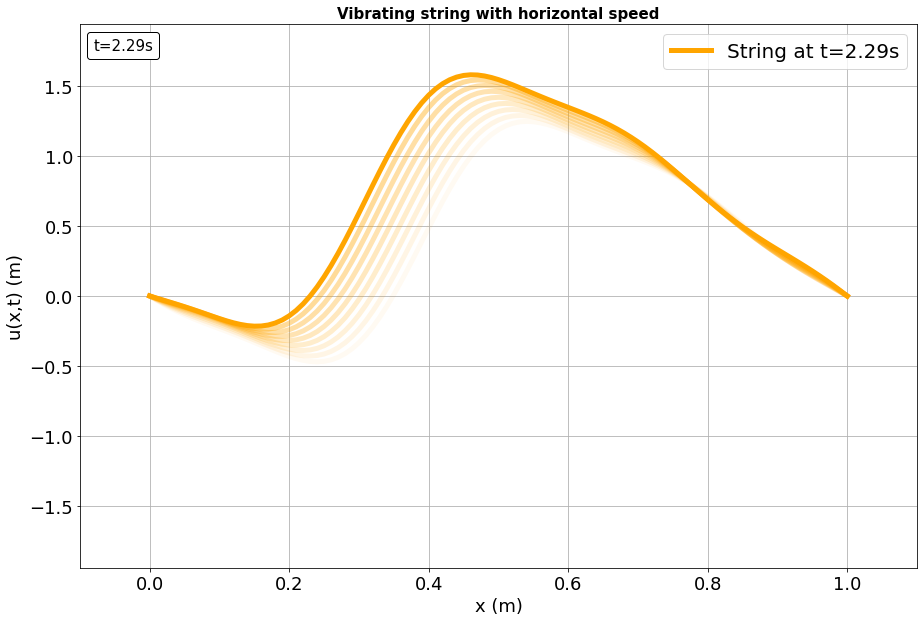

In [102]:
matplotlib.rcParams.update({'font.size': 18})
img_saver("String/c=3_v=2c_noise=0_modes=0.91_0.26_0.10_0.07_0.00_dt=0.010_dx=0.010.npz")

In [49]:
data = np.load("string_data/c=1_v=0.3c_noise=0.0_modes=0.39_0.26_t_final=10_nr=1000.npz")
x = data["X"]
print(x[2]-x[1])

0.005


In [33]:
def derivative_check(filename):
    """computes the analytical derivatives to see if the data adheres to the pde, if data=pde the pde should be 0"""
    
    data = np.load(filename)
    x = data["X"]
    time = data["t"]
    coefs = data["coefs"]
    c = data["c"]
    v = data["v"]
    
    omega = np.zeros(coefs.shape[0])
    k_rev = np.zeros(coefs.shape[0])
    k_fwd = np.zeros(coefs.shape[0])
    phi   = np.zeros(coefs.shape[0])
    coiso = 1

    for i in range(coefs.shape[0]):

        n = i+1
        omega[i] = n*np.pi*(c**2-v**2)/c
        k_rev[i] = n*np.pi*(c+v)/c
        k_fwd[i] = n*np.pi*(c-v)/c
        phi[i]   = -n*(np.pi*(c+v)/(2*c)-np.pi/2)



    du2_dx2  = np.zeros((len(time),len(x)))
    du2_dxdt = np.zeros((len(time),len(x)))
    du2_dt2  = np.zeros((len(time),len(x)))

    for b,t in enumerate(time):

        sum1  = 0
        sum2  = 0
        sum3  = 0

        for n in range(coefs.shape[0]):

            C1     = coefs[n] * np.sin(k_fwd[n]*x - omega[n]*t - phi[n])
            C2     = coefs[n] * np.sin(k_rev[n]*x + omega[n]*t + phi[n])

            sum1 += -k_fwd[n]**2*C1 - k_rev[n]**2*C2
            sum2 += +k_fwd[n]*omega[n]*C1  - k_rev[n]*omega[n]*C2
            sum3 += -omega[n]**2*C1 - omega[n]**2*C2

        du2_dx2[b,:]  = sum1
        du2_dxdt[b,:] = sum2
        du2_dt2[b,:]  = sum3
    
    pde = du2_dt2 - (c**2-v**2)*du2_dx2 + 2*v*du2_dxdt
    print(np.mean(np.abs(pde)))
    print(np.mean(np.abs(du2_dt2)))

In [34]:
derivative_check("resolution/data/spatial/c=3_v=0.5c_noise=0.0_modes=0.50_0.48_dt=0.010_dx=0.005.npz")

2.5692625197067185e-14
135.7691042135392
